<a href="https://colab.research.google.com/github/nishakya-silva/bioHack/blob/main/BioHack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
!pip install shap
import shap
# For reproducibility
np.random.seed(42)

In [ ]:
import pandas as pd
import numpy as np

path_hist = 'https://raw.githubusercontent.com/nishakya-silva/bioHack/main/Dengue_Data%20(2010-2020).xlsx'
path_weather = 'https://raw.githubusercontent.com/nishakya-silva/bioHack/main/dengue_data_with_weather_data.csv'


#Load the datasets
# Use read_excel for the .xlsx file and read_csv for the .csv file
df_historical = pd.read_excel(path_hist)
df_weather = pd.read_csv(path_weather)

#Harmonize column names
df_historical.rename(columns={'City': 'District', 'Value': 'Cases'}, inplace=True)
df_historical['Date'] = pd.to_datetime(df_historical['Date'])

# Create new 'Year' and 'Month' columns from the Date
df_historical['Year'] = df_historical['Date'].dt.year
df_historical['Month'] = df_historical['Date'].dt.month
df_historical.drop(columns=['Date'], inplace=True)

#Combine them
full_df = pd.concat([df_historical, df_weather], ignore_index=True)

geo_reference = df_weather[['District', 'Province', 'Latitude', 'Longitude', 'Elevation']].drop_duplicates(subset=['District'])
full_df_cleaned = full_df.drop(columns=['Province', 'Latitude', 'Longitude', 'Elevation'], errors='ignore')
full_df = pd.merge(full_df_cleaned, geo_reference, on='District', how='left')

#Handle missing data (Innovation: Monthly Mean Imputation)
weather_cols = ['Temp_avg', 'Precipitation_avg', 'Humidity_avg']
for col in weather_cols:
    if col in full_df.columns:
        # Fill NaN values with the mean of that column for that specific month
        full_df[col] = full_df.groupby('Month')[col].transform(lambda x: x.fillna(x.mean()))

print("Data successfully merged and weather gaps filled!")
print(full_df.head())

Data successfully merged and weather gaps filled!
  District  Cases  Year  Month   Temp_avg  Precipitation_avg  Humidity_avg  \
0  Colombo    584  2010      1  25.107024           4.042762     81.092381   
1  Colombo    606  2010      2  25.897024           2.473952     78.227143   
2  Colombo    294  2010      3  26.938345           1.986438     75.739865   
3  Colombo    224  2010      4  27.683286           3.993190     78.686667   
4  Colombo    296  2010      5  27.764000           5.759524     80.869048   

  Province  Latitude  Longitude  Elevation  
0  Western  6.924429   79.90725        4.0  
1  Western  6.924429   79.90725        4.0  
2  Western  6.924429   79.90725        4.0  
3  Western  6.924429   79.90725        4.0  
4  Western  6.924429   79.90725        4.0  


In [ ]:

urban_scores = {
    "Colombo": 10, "Gampaha": 9, "Kalutara": 7, "Kandy": 8, "Matale": 5,
    "Nuwara Eliya": 4, "Galle": 7, "Matara": 6, "Hambantota": 5, "Jaffna": 6,
    "Kilinochchi": 3, "Mannar": 3, "Vavuniya": 4, "Mullaitivu": 2, "Batticaloa": 5,
    "Ampara": 4, "Trincomalee": 5, "Kurunegala": 6, "Puttalam": 5, "Anuradhapura": 4,
    "Polonnaruwa": 3, "Badulla": 4, "Monaragala": 2, "Ratnapura": 5, "Kegalle": 5
}

# Fix: Mapping directly to the values in your urban_scores dictionary
full_df['Urban_Score'] = full_df['District'].map(urban_scores).fillna(5)

# 1. Ensure data is sorted for time-series shifting
full_df = full_df.sort_values(by=['District', 'Year', 'Month'])

# 2. Create Multi-Month Lags (1, 2, and 3 months)
# This accounts for the slow biological response of Dengue to weather
lag_months = [1, 2, 3]

for lag in lag_months:
    full_df[f'Precip_Lag{lag}'] = full_df.groupby('District')['Precipitation_avg'].shift(lag)
    full_df[f'Temp_Lag{lag}'] = full_df.groupby('District')['Temp_avg'].shift(lag)

# 3. Create 1-month lag for Cases (Momentum feature)
full_df['Cases_Lag1'] = full_df.groupby('District')['Cases'].shift(1)

print("Urban_Score added and 1, 2, 3-month lags created successfully!")

# 4. List of all new lag columns to check
lag_cols = [f'Precip_Lag{i}' for i in lag_months] + \
           [f'Temp_Lag{i}' for i in lag_months] + \
           ['Cases_Lag1']

# 5. Remove rows where any lag is NaN
# Note: Because we have a 3-month lag, the first 3 months of every district will be dropped
if all(col in full_df.columns for col in lag_cols):
    full_df.dropna(subset=lag_cols, inplace=True)
    print(f"Rows with NaN lags removed. Total rows remaining: {len(full_df)}")
else:
    print("One or more lag columns were not found.")

Urban_Score added and 1, 2, 3-month lags created successfully!
Rows with NaN lags removed. Total rows remaining: 4116


In [ ]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

# Define features and target
features = [
    'Latitude', 'Longitude', 'Elevation', 'Month','Urban_Score',
    'Precip_Lag1', 'Precip_Lag2', 'Precip_Lag3',
    'Temp_Lag1', 'Temp_Lag2', 'Temp_Lag3',
    'Cases_Lag1'
]
X = full_df[features]
y = full_df['Cases']

# Split: Train on 80%, Test on 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Initialize and Train XGBoost
model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8
)

model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

--- Model Performance ---
Mean Absolute Error: 48.09 cases
R-squared Score: 0.70


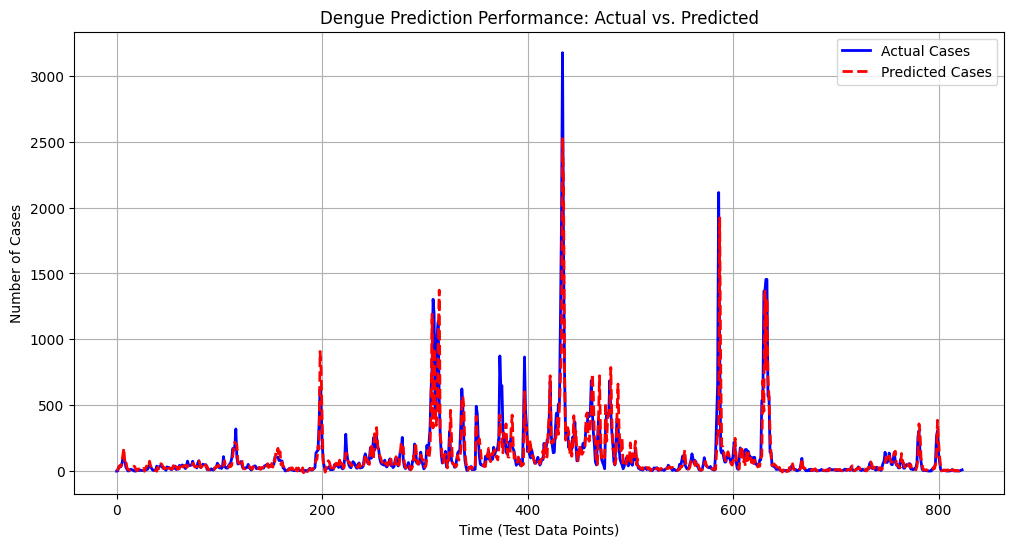

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score

# 1. Make predictions on the test set (the 20% we hid earlier)
predictions = model.predict(X_test)

# 2. Calculate Evaluation Metrics
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"--- Model Performance ---")
print(f"Mean Absolute Error: {mae:.2f} cases")
print(f"R-squared Score: {r2:.2f}")

# 3. Visualize: Actual vs. Predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual Cases', color='blue', linewidth=2)
plt.plot(predictions, label='Predicted Cases', color='red', linestyle='--', linewidth=2)
plt.title('Dengue Prediction Performance: Actual vs. Predicted')
plt.xlabel('Time (Test Data Points)')
plt.ylabel('Number of Cases')
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipython-input-186218984.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


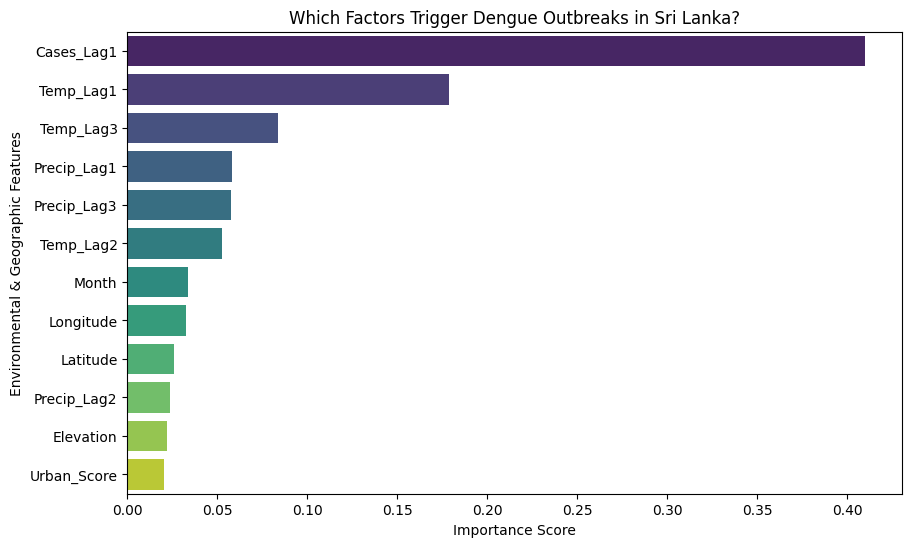

In [72]:
import seaborn as sns # <--- This fixes the 'sns' error
import matplotlib.pyplot as plt

# Get feature importance
importances = model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Which Factors Trigger Dengue Outbreaks in Sri Lanka?')
plt.xlabel('Importance Score')
plt.ylabel('Environmental & Geographic Features')
plt.show()

In [73]:
import joblib

joblib.dump(model, "final_dengue_model.pkl")
print("Saved in notebook workspace")


Saved in notebook workspace


In [76]:
import numpy as np


district_map = {
    "Colombo": {"Latitude": 6.924429, "Longitude": 79.90725},
    "Gampaha": {"Latitude": 7.0650263, "Longitude": 79.96622},
    "Kalutara": {"Latitude": 6.572935, "Longitude": 80.02519},
    "Kandy": {"Latitude": 7.275923, "Longitude": 80.62659},
    "Matale": {"Latitude": 7.4868193, "Longitude": 80.52632},
    "Nuwara Eliya": {"Latitude": 6.9947276, "Longitude": 80.73418},
    "Galle": {"Latitude": 6.0808434, "Longitude": 80.23373},
    "Matara": {"Latitude": 6.1511426, "Longitude": 81.127815},
    "Hambantota": {"Latitude": 5.940246, "Longitude": 80.55},
    "Jaffna": {"Latitude": 9.66608, "Longitude": 80.034874},
    "Kilinochchi": {"Latitude": 9.384886, "Longitude": 80.38228},
    "Mannar": {"Latitude": 8.963093, "Longitude": 79.96543},
    "Vavuniya": {"Latitude": 8.752197, "Longitude": 80.53448},
    "Mulativu": {"Latitude": 9.244288, "Longitude": 80.789246},
    "Batticaloa": {"Latitude": 7.6977153, "Longitude": 81.65106},
    "Ampara": {"Latitude": 7.275923, "Longitude": 81.693474},
    "Trincomalee": {"Latitude": 8.611599, "Longitude": 81.170395},
    "Kurunegala": {"Latitude": 7.4868193, "Longitude": 80.37352},
    "Puttalam": {"Latitude": 8.04921, "Longitude": 79.84615},
    "Anuradhapura": {"Latitude": 8.330404, "Longitude": 80.42882},
    "Polonnaruwa": {"Latitude": 7.908612, "Longitude": 81.01536},
    "Badulla": {"Latitude": 6.9947276, "Longitude": 81.03797},
    "Moneragala": {"Latitude": 6.8541303, "Longitude": 81.35636},
    "Ratnapura": {"Latitude": 6.7135324, "Longitude": 80.38688},
    "Kegalle": {"Latitude": 7.275923, "Longitude": 80.32176}
}

# Choose the district for prediction
district = "Kegalle"

# Look up coordinates
coords = district_map[district]
urban_val = urban_scores.get(district, 5)
# 1. Update features list to include 3-month depth
features = [
    'Latitude', 'Longitude', 'Elevation', 'Month','Urban_Score',
    'Precip_Lag1', 'Precip_Lag2', 'Precip_Lag3',
    'Temp_Lag1', 'Temp_Lag2', 'Temp_Lag3',
    'Cases_Lag1'
]

# 2. Prepare new data for Kegalle (Scenario: Rain was high 2 months ago)
new_data = pd.DataFrame(
    [[coords["Latitude"], coords["Longitude"], 4.0, 5,urban_val,
      250.0, 310.0, 150.0,  # Precipitation (Lag 1, 2, 3)
      28.5, 29.2, 27.8,     # Temperature (Lag 1, 2, 3)
      145]],                # Cases_Lag1
    columns=features
)

# 3. Calculate Prediction and Confidence Range
train_preds = model.predict(X_train)
residuals = y_train - train_preds
std_residual = np.std(residuals)

pred = model.predict(new_data)[0]
lower = max(0, pred - 1.96 * std_residual)
upper = pred + 1.96 * std_residual

print(f"--- Enhanced Forecast for {district} ---")
print(f"Predicted Dengue Cases: {int(pred)}")
print(f"95% Confidence Range: {int(lower)} - {int(upper)}")

--- Enhanced Forecast for Kegalle ---
Predicted Dengue Cases: 187
95% Confidence Range: 93 - 280


In [77]:
import shap
import numpy as np

# Explain the model for this new data point
explainer = shap.TreeExplainer(model)
shap_values = explainer(new_data)

# Extract values
individual_shap = shap_values.values[0]  # SHAP impact per feature
feature_vals = new_data.iloc[0]
predicted_val = pred  # from previous range prediction
lower_val = lower
upper_val = upper
base_value = shap_values.base_values[0]

print(f"--- Automated Clinical Report: {district} ---")
print(f"Predicted Cases for Next Month: {int(predicted_val)}")
print(f"Prediction Range (approx 95%): {int(lower_val)} - {int(upper_val)}")
print(f"National Average Base Risk: {int(base_value)}\n")
print("Reasoning for this Prediction:")

features = ['Latitude', 'Longitude', 'Elevation', 'Month', 'Precip_Lag1', 'Temp_Lag1', 'Cases_Lag1']

for i, feature in enumerate(features):
    impact = individual_shap[i]
    val = feature_vals[feature]

    if abs(impact) > 2:  # threshold for significance
        direction = "INCREASED" if impact > 0 else "DECREASED"
        avg_val = X_train[feature].mean()
        context = "higher than average" if val > avg_val else "lower than average"

        print(f" - {feature} ({val}, {context}): This {direction} the risk by {abs(int(impact))} cases.")

summary_text = ("high environmental risk" if predicted_val > base_value
                else "lower than the national average")
print(f"\nSummary: The forecast of {int(predicted_val)} cases in {district} is primarily {summary_text}.")


--- Automated Clinical Report: Kegalle ---
Predicted Cases for Next Month: 187
Prediction Range (approx 95%): 93 - 280
National Average Base Risk: 212

Reasoning for this Prediction:
 - Latitude (7.275923, lower than average): This INCREASED the risk by 6 cases.
 - Longitude (80.32176, lower than average): This DECREASED the risk by 11 cases.
 - Month (5.0, lower than average): This DECREASED the risk by 10 cases.
 - Temp_Lag1 (28.5, higher than average): This INCREASED the risk by 59 cases.
 - Cases_Lag1 (145.0, lower than average): This INCREASED the risk by 42 cases.

Summary: The forecast of 187 cases in Kegalle is primarily lower than the national average.
